In [ ]:
%pip install fsspec
%pip install seaborn
%pip install gensim
%pip install --upgrade certifi
%pip install --upgrade pip
%pip install unidecode

In [92]:
import fsspec as fss
import nltk
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt


import csv
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import nltk
import ssl #Variant to download nltk on Mac

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()
nltk.download('stopwords')

2024-03-19 21:24:33.905 Python[83082:4225599] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kevinhernandez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data Load

In [4]:
import os
import pandas as pd
import json

configfile = open("../config.json")
configfile = json.load(configfile)


/Users/kevinhernandez/Library/CloudStorage/OneDrive-Personal/Personal/Universidad/2. Maestria/MBIA_UVG/1. Cursos/Segundo Año/2.4 Text Analytics/Proyecto/data2/


In [5]:
# Specify the path to the folder containing CSV files

folder_path = configfile["datapath"]

# Get a list of all CSV files in the folder

# List files containing 'item' in the file name
req_item = [file for file in os.listdir(folder_path) if 'item' in file]
# List files containing 'sla' in the file name
task_sla = [file for file in os.listdir(folder_path) if 'sla' in file]

# Initialize an empty DataFrame to store the concatenated data
tickets = pd.DataFrame()
pause = pd.DataFrame()

# Loop through each CSV file and concatenate its data to the DataFrame
for csv_file in req_item:
    file_path = os.path.join(folder_path, csv_file)
    df = pd.read_csv(file_path, encoding = 'latin-1')
    tickets = pd.concat([tickets, df], ignore_index=True)

for csv_file in task_sla:
    file_path = os.path.join(folder_path, csv_file)
    df = pd.read_csv(file_path, encoding = 'latin-1')
    pause = pd.concat([pause, df], ignore_index = True)
    
# Save the concatenated DataFrame to a new CSV file
tickets.to_csv(folder_path +'tickets.csv', index=False)
pause.to_csv(folder_path + 'pause.csv', index =False)

#Change types
tickets = tickets.loc[:,['number','cat_item','u_pais', 'assigned_to','opened_at','request.opened_by','comments']]
tickets = tickets.astype(str)

pause = pause.loc[:,['task','pause_duration']]

# #Get the tickets that were paused
tickets = tickets.merge(pause,left_on ='number', right_on = 'task')

# Identify duplicate rows based on the 'Name' column
duplicate_mask = tickets['number'].duplicated()

# Filter and delete the duplicate rows
tickets = tickets[~duplicate_mask]
tickets = tickets.sort_values(by='pause_duration', ascending=False)

# #Filter tickets that were paused
tickets = tickets[tickets['pause_duration'] > 0]

# Save the concatenated DataFrame to a new CSV file
tickets.to_csv(folder_path + 'rawdata.csv')

{'datapath': '/Users/kevinhernandez/Library/CloudStorage/OneDrive-Personal/Personal/Universidad/2. Maestria/MBIA_UVG/1. Cursos/Segundo Año/2.4 Text Analytics/Proyecto/data2/'}


/var/folders/pj/f6r9gzb90qb6cgnwvdn1bhx80000gn/T/ipykernel_60263/396128323.py:27: DtypeWarning: Columns (21,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding = 'latin-1')


In [6]:
print(tickets)

tickets.head()
#pause.head()

             number                    cat_item            u_pais  \
211913  RITM0032806  Datos sensibles clientes              Brasil   
219643  RITM0021470  Datos sensibles clientes           Argentina   
219641  RITM0021469  Datos sensibles clientes           Argentina   
219599  RITM0025494  Datos sensibles clientes               Chile   
219637  RITM0030484  Datos sensibles clientes               Chile   
...             ...                         ...               ...   
48658   RITM0083838      Master Data Extraction               BBS   
208549  RITM0056990            Artículos Varios  Brenntag Pacific   
250295  RITM0021570  Datos sensibles clientes               Chile   
209287  RITM0055119            Artículos Varios            Brasil   
209285  RITM0055095            Artículos Varios            Brasil   

              assigned_to            opened_at  \
211913  Nathaly Rodriguez  15/06/2021 08:21:53   
219643          Luis Cruz  24/01/2021 16:06:05   
219641          Luis 

,number,cat_item,u_pais,assigned_to,opened_at,request.opened_by,comments,task,pause_duration
211913,RITM0032806,Datos sensibles clientes,Brasil,Nathaly Rodriguez,15/06/2021 08:21:53,Lidiane Daniela Alexandrina Gaparri,15/06/2021 13:06:55 - BLA_MDM (Additional com...,RITM0032806,39924475
219643,RITM0021470,Datos sensibles clientes,Argentina,Luis Cruz,24/01/2021 16:06:05,Marianela Hernandez,28/10/2021 10:27:15 - BLA_MDM (Additional com...,RITM0021470,23859950
219641,RITM0021469,Datos sensibles clientes,Argentina,Luis Cruz,24/01/2021 15:56:33,Marianela Hernandez,28/10/2021 10:28:35 - BLA_MDM (Additional com...,RITM0021469,23859946
219599,RITM0025494,Datos sensibles clientes,Chile,Luis Cruz,15/03/2021 15:08:26,Edgardo Carrasco Palma,28/10/2021 12:14:19 - BLA_MDM (Additional com...,RITM0025494,19546476
219637,RITM0030484,Datos sensibles clientes,Chile,Luis Cruz,13/05/2021 16:15:19,Josue Cofre Diaz,28/10/2021 10:31:09 - BLA_MDM (Additional com...,RITM0030484,14442511


### Exploratory Data Analysis

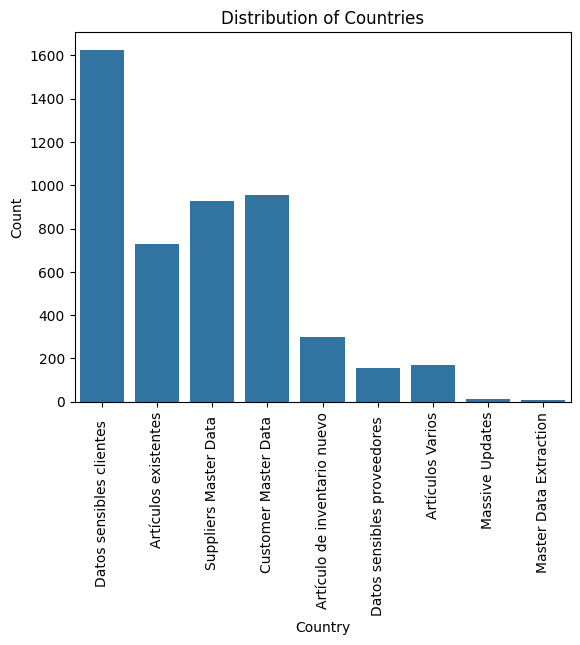

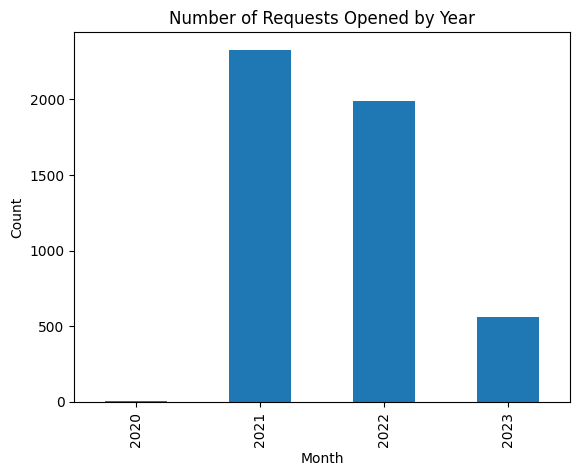

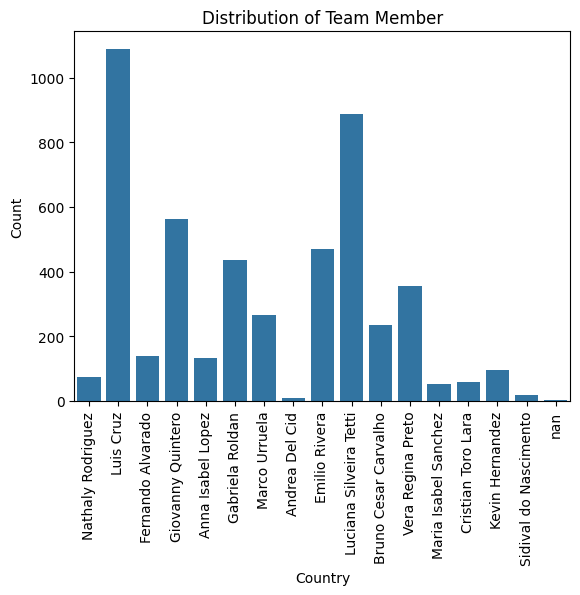

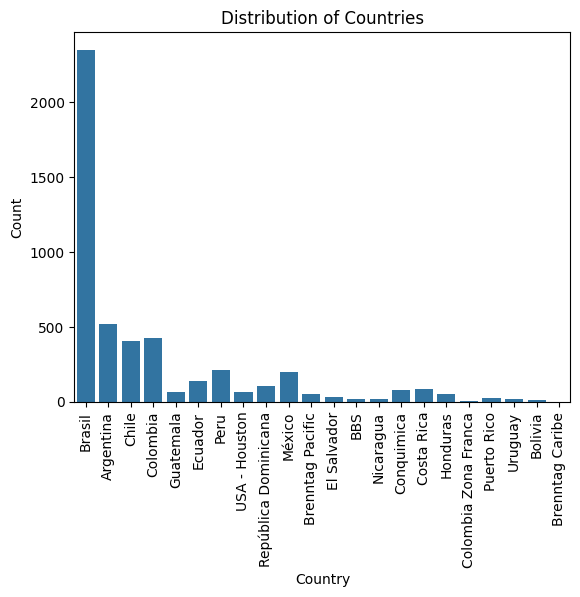

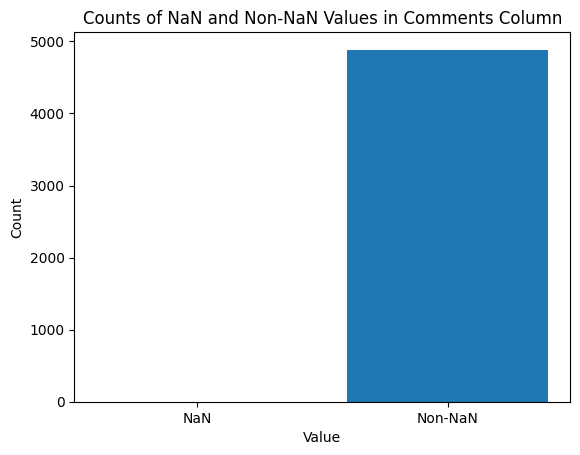

In [36]:
#Installing libraries
import seaborn as sns

# Explore the data
tickets.head()  # Display the first few rows
tickets['cat_item'].value_counts()  # Distribution of 'cat_item' variable
tickets['u_pais'].value_counts()  # Distribution of 'u_pais' variable
tickets['assigned_to'].value_counts()  # Distribution of 'assigned_to' variable

# Data preprocessing and feature engineering
tickets['opened_at'] = pd.to_datetime(tickets['opened_at'])  # Convert 'opened_at' to datetime
tickets['year'] = tickets['opened_at'].dt.year  # Extract year
tickets['month'] = tickets['opened_at'].dt.month  # Extract month
tickets['day'] = tickets['opened_at'].dt.day  # Extract day
tickets['hour'] = tickets['opened_at'].dt.hour  # Extract hour

# Visualize the data

sns.countplot(data=tickets, x='cat_item')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Distribution of Countries')
plt.xticks(rotation=90)
plt.show()


tickets['opened_at'].dt.year.value_counts().sort_index().plot(kind='bar')  # Number of requests opened by month
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Number of Requests Opened by Year')
plt.show()

sns.countplot(data=tickets, x='assigned_to')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Distribution of Team Member')
plt.xticks(rotation=90)
plt.show()

# Distribution of 'u_pais' variable using a countplot
sns.countplot(data=tickets, x='u_pais')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Distribution of Countries')
plt.xticks(rotation=90)
plt.show()


# Count NaN and non-NaN values in the 'comments' column
nan_count = tickets['comments'].isna().sum()
non_nan_count = tickets['comments'].notna().sum()

# Create a bar plot to visualize the counts
plt.bar(['NaN', 'Non-NaN'], [nan_count, non_nan_count])
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Counts of NaN and Non-NaN Values in Comments Column')
plt.show()

### Data Processing

In [98]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models

try:
    from nltk.corpus import stopwords
    stopwords.words('english')  # or any other language you are interested in
    print("NLTK stopwords module is installed correctly.")
except ImportError:
    print("NLTK stopwords module is not installed. Please install it using: pip install nltk")
except LookupError:
    print("NLTK stopwords data is not downloaded. Please download it using: nltk.download('stopwords')")

NLTK stopwords module is installed correctly.


In [99]:
# Import necessary libraries
import re
from nltk.corpus import stopwords
from unidecode import unidecode


#Split every comment into an element of the list
def split_string(text):
    regex_pattern = r'(\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2}|\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) - .+?\)' #pattern that detects the start of a comment
    matches = re.findall(regex_pattern, text)
    substrings = re.split(regex_pattern, text)
    result = []
    for i in range(len(matches)):
        result.append(substrings[i].strip())
        result.append(matches[i])
    result.append(substrings[-1].strip())
    return result



# Define the preprocessing function
def preprocess_text(text):
    # Generate stop words
    stop_words = list(set(stopwords.words('english') + stopwords.words('spanish') + stopwords.words('portuguese')))

    # Additional stop words to remove
    additional_stop_words = ['additional', 'reply', 'nan', 'brenntagla', 'ref', 'comentarios', 'comment', 'bruno', 'ltda', 'cesar', 'carvalho', 
    'bla_mdm', 'bom', 'boa', 'emilio', 'maria', 'sanchez', 'com', 'attachment', 'communication', 'and', 'the', 'from', 
    'cad', 'of', 'or', 's', 'rmccolaugh', 'chamado', 'ok', 'favor', 'erivera', 'ttejeda', 'tilson', 'dominguez', 'hola', 
    'brenntag', 'nascimento', 'dia', 'saludos', 'company', 'you', 'efetuado', 'tarde', 'da', 'c', 'm', 'día', 'buen', 
    'this', 'others', 'is', 'brasil', 'ind', 'eireli', 'p', 'cc', 'microsoft', 'outlook', 'enviado', 'window', 'do', 
    'industria', 'android', 'for', 'please', 'buenas', 'tardes', 'gracias', 'aka', 'si', 'http', 'essa', 'd', 'ritm', 
    'oracle', 'solicitud', 'solicitudes', 'asignado', 'l', 'pl', 'ticket', 'adjunto', 'cadastrado', 'atualizado', 
    'cadastro', 'Buenos', 'Días', 'mdm', 'ob', 'sa', 'colombia', 'correo', 'anexo', 'aberto', 'pantalla', 'email', 
    'Colombia', 'agregada', 'Email', 'aguardo', 'argentina', 'buenos', 'aires', 'data', 'master', 'cristian', 'quedo', 
    'atento', 'br', 'toro', 'voce', 'nao', 'electronic', 'lima', 'b', 'ja', 'novo', 'actualizada', 'actualizado', 'h', 
    'fernando', 'giovanny', 'quintero', 'giquintero', 'lcruz', 'luis', 'cruz', 'marco', 'urruela', 'jaquelin', 
    'jaramillo', 'rivera', 'santiago', 'gabriela', 'roldán', 'eva', 'vera', 'regina', 'prieto', 'marlin', 'diaz', 
    'madiaz', 'ajaramillo', 'lsilveira', 'sidival', 'isola', 'toledo', 'moreno', 'paola', 'lopez', 'roldan', 'marcelo','dominguez','rivera','argentina',
    'estabais','sa','mis','debido','se','cerrara','al','marianela','a','e','de','on','la','el','que','en','para','este','los','ha','los','almoco','pausa',
    'o','por','y','no','como','esta','fue','del','ya','con','lo','un','ser','verificar','em','me','any','caso','espera','segun','indicar','informar',
    'una','pero','via','foi','le','debe','tiene','to','na','conforme','ou','um','ficara','encuentra','esse','poi','chile']
    

    stop_words.extend(additional_stop_words)
    stop_words = set(additional_stop_words)
    
    #split every ticket comment as an element of a list
    result = split_string(text)
    #print(result)
    alltokens = []
    for word in result:
        
        # Apply preprocessing steps
        word = word.lower() #lower strings
        
        # Split the comments into an element of a list
        asunto = r"(?m)^(asunto:.*)$"
        matches = re.findall(asunto, word)
        if len(matches)>0:
            result = matches[0]
            result = re.sub(r"^\d+(.*?)(?=(asunto:|$))",'',word)
            #print(result)
        else:
            result = re.sub(r'(\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2}|\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) - .+?\)','',word)
        
        word = re.sub(r'\d+', '', word)  # Remove numbers
        word = re.sub(r'\s+', ' ', word)  # Remove extra whitespaces
        word = re.sub(r'[^\w'+']', ' ', word) #Remove non-alphanumeric characters
        tokens = word_tokenize(word)
        tokens = [unidecode(token) for token in tokens]

        # Lemmatize the words
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        tokens = [token for token in tokens if token not in stop_words]
        alltokens.extend(tokens)
    return alltokens

# Preprocess the comments
#comments = [tickets['comments'].tolist()[4]]  # Assuming 'df' is your DataFrame
comments = tickets['comments']  # Assuming 'df' is your DataFrame
comments = comments.tolist()

#print(comments[0:2])

preprocessed_comments = [preprocess_text(comment) for comment in comments]

# Print the stop words
#print(stop_words)
print(preprocessed_comments[0:2])

[['informacoes', 'financeira'], ['tiempo', 'pasado', 'sin', 'recibir', 'respuesta', 'captura', 'indicaciones', 'persona', 'encargadas', 'aprobar', 'estos', 'cambios', 'ibu', 'cualquier', 'duda', 'comentario', 'ambas', 'ibu', 'dependientes', 'mismo', 'gerente']]


### Data Modelling

In [100]:
# Create a dictionary representation of the comments
dictionary = corpora.Dictionary(preprocessed_comments)

# Convert the comments to a bag-of-words corpus
corpus = [dictionary.doc2bow(comment) for comment in preprocessed_comments]

# Apply the LDA topic modeling algorithm
num_topics = 3  # Define the number of topics
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=50)

# Print the topics
#for topic in lda_model.print_topics():
#    print(topic)

for topic_id, topic in lda_model.print_topics():
    print(f"Topic ID: {topic_id}\nWords: {topic}\n")

Topic ID: 0
Words: 0.012*"cliente" + 0.011*"fornecedor" + 0.008*"codigo" + 0.006*"cnpj" + 0.005*"comercio" + 0.005*"problemas" + 0.005*"endereco" + 0.005*"confirmar" + 0.005*"tambor" + 0.005*"informado"

Topic ID: 1
Words: 0.014*"cliente" + 0.010*"informacion" + 0.009*"proveedor" + 0.009*"datos" + 0.008*"nombre" + 0.007*"codigo" + 0.007*"direccion" + 0.006*"creacion" + 0.006*"razon" + 0.006*"social"

Topic ID: 2
Words: 0.037*"cliente" + 0.037*"direccion" + 0.019*"pago" + 0.017*"alta" + 0.015*"demanda" + 0.015*"ship" + 0.012*"ibu" + 0.012*"termino" + 0.012*"vendedor" + 0.008*"proposito"



### Data Visualization

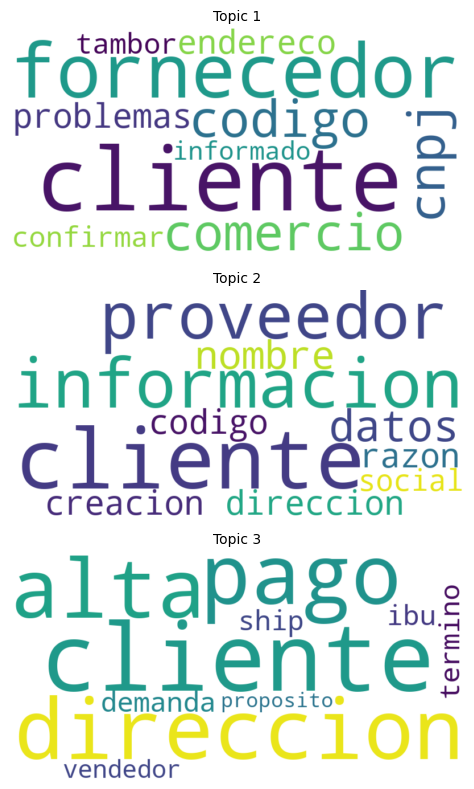

In [101]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Get the topics
topics = lda_model.show_topics()

# Create subplots for each topic
num_topics = len(topics)
fig, axes = plt.subplots(num_topics, 1, figsize=(8, 8), sharex=True, dpi=100)

# Generate word clouds for each topic
for i, (topic_num, topic_words) in enumerate(topics):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_words)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title('Topic ' + str(topic_num + 1), fontsize=10)  # Update the title with topic_num + 1
    axes[i].axis('off')

plt.tight_layout()
plt.show()


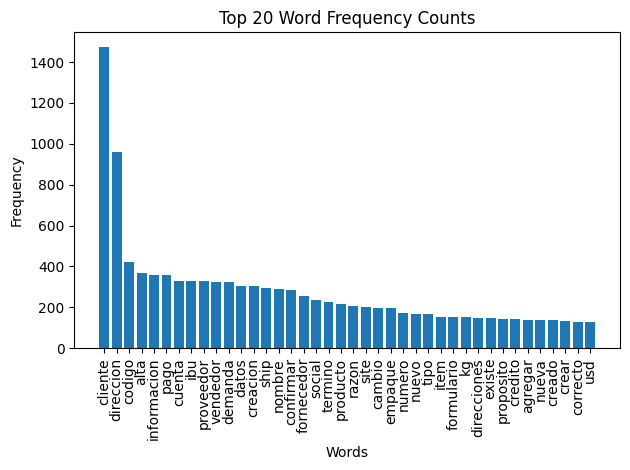

[('cliente', 1472), ('direccion', 962), ('codigo', 420), ('alta', 367), ('informacion', 359), ('pago', 358), ('cuenta', 331), ('ibu', 328), ('proveedor', 328), ('vendedor', 326), ('demanda', 324), ('datos', 306), ('creacion', 302), ('ship', 295), ('nombre', 292), ('confirmar', 286), ('fornecedor', 256), ('social', 234), ('termino', 227), ('producto', 218), ('razon', 208), ('site', 201), ('cambio', 196), ('empaque', 195), ('numero', 174), ('nuevo', 168), ('tipo', 167), ('item', 155), ('formulario', 155), ('kg', 153), ('direcciones', 146), ('existe', 146), ('proposito', 145), ('credito', 141), ('agregar', 139), ('nueva', 138), ('creado', 137), ('crear', 133), ('correcto', 129), ('usd', 128)]


: 

In [102]:
from collections import Counter

# Flatten the nested list of tokens
flattened_tokens = [token for sublist in preprocessed_comments for token in sublist]

# Count the word frequency
word_frequency = Counter(flattened_tokens)

# Get the top 20 words and their counts
top_words = word_frequency.most_common(40)  # Returns a list of tuples (word, count)

# Extract the words and their counts
words = [word for word, count in top_words]
counts = [count for word, count in top_words]

# Create a bar plot
plt.bar(words, counts)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Word Frequency Counts')
plt.tight_layout()  # Adjust the spacing of the plot
plt.show()
print(top_words)